In [ ]:
#############################################################################
# zlib License
#
# (C) 2023 Zach Flowers, Murtaza Safdari <musafdar@cern.ch>
#
# This software is provided 'as-is', without any express or implied
# warranty.  In no event will the authors be held liable for any damages
# arising from the use of this software.
#
# Permission is granted to anyone to use this software for any purpose,
# including commercial applications, and to alter it and redistribute it
# freely, subject to the following restrictions:
#
# 1. The origin of this software must not be misrepresented; you must not
#    claim that you wrote the original software. If you use this software
#    in a product, an acknowledgment in the product documentation would be
#    appreciated but is not required.
# 2. Altered source versions must be plainly marked as such, and must not be
#    misrepresented as being the original software.
# 3. This notice may not be removed or altered from any source distribution.
#############################################################################

# Imports

In [1]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
import logging
import i2c_gui
import i2c_gui.chips
import random
from i2c_gui.usb_iss_helper import USB_ISS_Helper
from i2c_gui.fpga_eth_helper import FPGA_ETH_Helper
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import time
from tqdm import tqdm
# from i2c_gui.chips.etroc2_chip import register_decoding
import os, sys
import multiprocessing
os.chdir(f'/home/{os.getlogin()}/ETROC2/ETROC_DAQ')
import run_script
import parser_arguments
import importlib
importlib.reload(run_script)
import datetime
import pandas
from pathlib import Path
import subprocess
import sqlite3
from notebooks.notebook_helpers import *
from fnmatch import fnmatch
import scipy.stats as stats
from math import ceil
from numpy import savetxt
from numpy.random import permutation

# Set defaults

In [2]:
# !!!!!!!!!!!!
# It is very important to correctly set the chip name, this value is stored with the data
# chip_names = ["ET2_EPIR_Pair1", "ET2p01_BAR_4", "ET2p01_BAR_6", "ET2_EPIR_Pair4"]
# chip_fignames = ["ET2 EPIR Pair 1", "ET2.01 Barcelona 4", "ET2.01 Barcelona 6", "ET2 EPIR Pair4"]
chip_names = ["ETROC2.03_BARE2"]
chip_fignames = ["ETROC2.03 BARE2"]
chip_figtitles = chip_names

# 'The port name the USB-ISS module is connected to. Default: /dev/ttyACM0'
port = "/dev/ttyACM0"
# I2C addresses for the pixel block and WS
# chip_addresses = [0x60, 0x61, 0x62, 0x63]
chip_addresses = [0x60]
ws_addresses = [None, None, None, None]

fig_outdir = Path('../ETROC-figures')
fig_outdir = fig_outdir / (datetime.date.today().isoformat() + '_Array_Test_Results')
fig_outdir.mkdir(exist_ok=True)
fig_path = str(fig_outdir)

# Make i2c_connection class object

In [3]:
# i2c_conn = self, port, chip_addresses, chip_names, chip_fc_delays
i2c_conn = i2c_connection(port,chip_addresses,ws_addresses,chip_names,[("1","1"),("1","1"),("1","1"), ("1","1")])

# Config chips

### Key is (Disable Pixels, Auto Cal, Chip Peripherals, Basic Peri Reg Check, Pixel Check)

In [4]:
# (WS Prep Pixel and Peri) - 0 - (disable & auto_cal all pixels) - (disable default all pixels) - (auto_TH_CAL) - (set basic peripherals) - (peripheral reg check) -  (pixel ID check)
i2c_conn.config_chips('00100101')
# i2c_conn.config_chips('00001111') # disable and more fun things
# i2c_conn.config_chips('00000100') # set basic peripherals
# i2c_conn.config_chips('00010000') # calibrate only
# i2c_conn.config_chips('00000001') # pixel ID check (I2C check)
# i2c_conn.config_chips('10000000') # ws init
# i2c_conn.disable_all_pixels(chip_address=chip_addresses[1])

Passed pixel check for chip: 0x60
Peripherals set for chip: 0x60
Disabled pixels (Bypass, TH-3f DAC-3ff) for chip: 0x60
Disabled pixels (Bypass, TH-3f DAC-3ff) for chip: 0x60


Calibrating row: 100%|██████████| 16/16 [01:28<00:00,  5.52s/it]

Auto calibration finished for chip: 0x60


## Set power mode to high if currents are too low

In [ ]:
# full_col_list, full_row_list = np.meshgrid(np.arange(16),np.arange(16))
# full_scan_list = list(zip(full_row_list.flatten(),full_col_list.flatten()))
# for address in chip_addresses:
#     i2c_conn.set_power_mode_scan_list(address, full_scan_list, 'high')

In [ ]:
for chip_address,chip_name in zip(chip_addresses,chip_names):
    chip = i2c_conn.get_chip_i2c_connection(chip_address)

    chip.read_all_block("ETROC2", "Peripheral Config")

    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "singlePort")           # Set data output to right port only
    handle.set('1')
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "serRateLeft")          # Set Data Rates to 320 mbps
    handle.set(hex(0b00))
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "serRateRight")         # ^^
    handle.set(hex(0b00))
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "triggerGranularity")   # only for trigger bit
    handle.set(hex(0x01))
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "mergeTriggerData")           # Set data output to right port only
    handle.set('1')

    # handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "onChipL1AConf")           # Set data output to right port only
    # handle.set('11')
    
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "fcClkDelayEn")           # Set data output to right port only
    handle.set('1')
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "fcDataDelayEn")           # Set data output to right port only
    handle.set('1')

    # handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "asyResetGlobalReadout")           # Set data output to right port only
    # handle.set('0')
    # handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "asyResetGlobalReadout")           # Set data output to right port only
    # handle.set('1')


    # handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "chargeInjectionDelay")           # Set data output to right port only
    # handle.set(hex(0x0a))

    chip.write_all_block("ETROC2", "Peripheral Config")
    print(f"Peripherals set for chip: {hex(chip_address)}")

## Visualize the learned Baselines (BL) and Noise Widths (NW)

Note that the NW represents the full width on either side of the BL

In [5]:
#%%
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.show()

<Figure size 1000x1000 with 0 Axes>

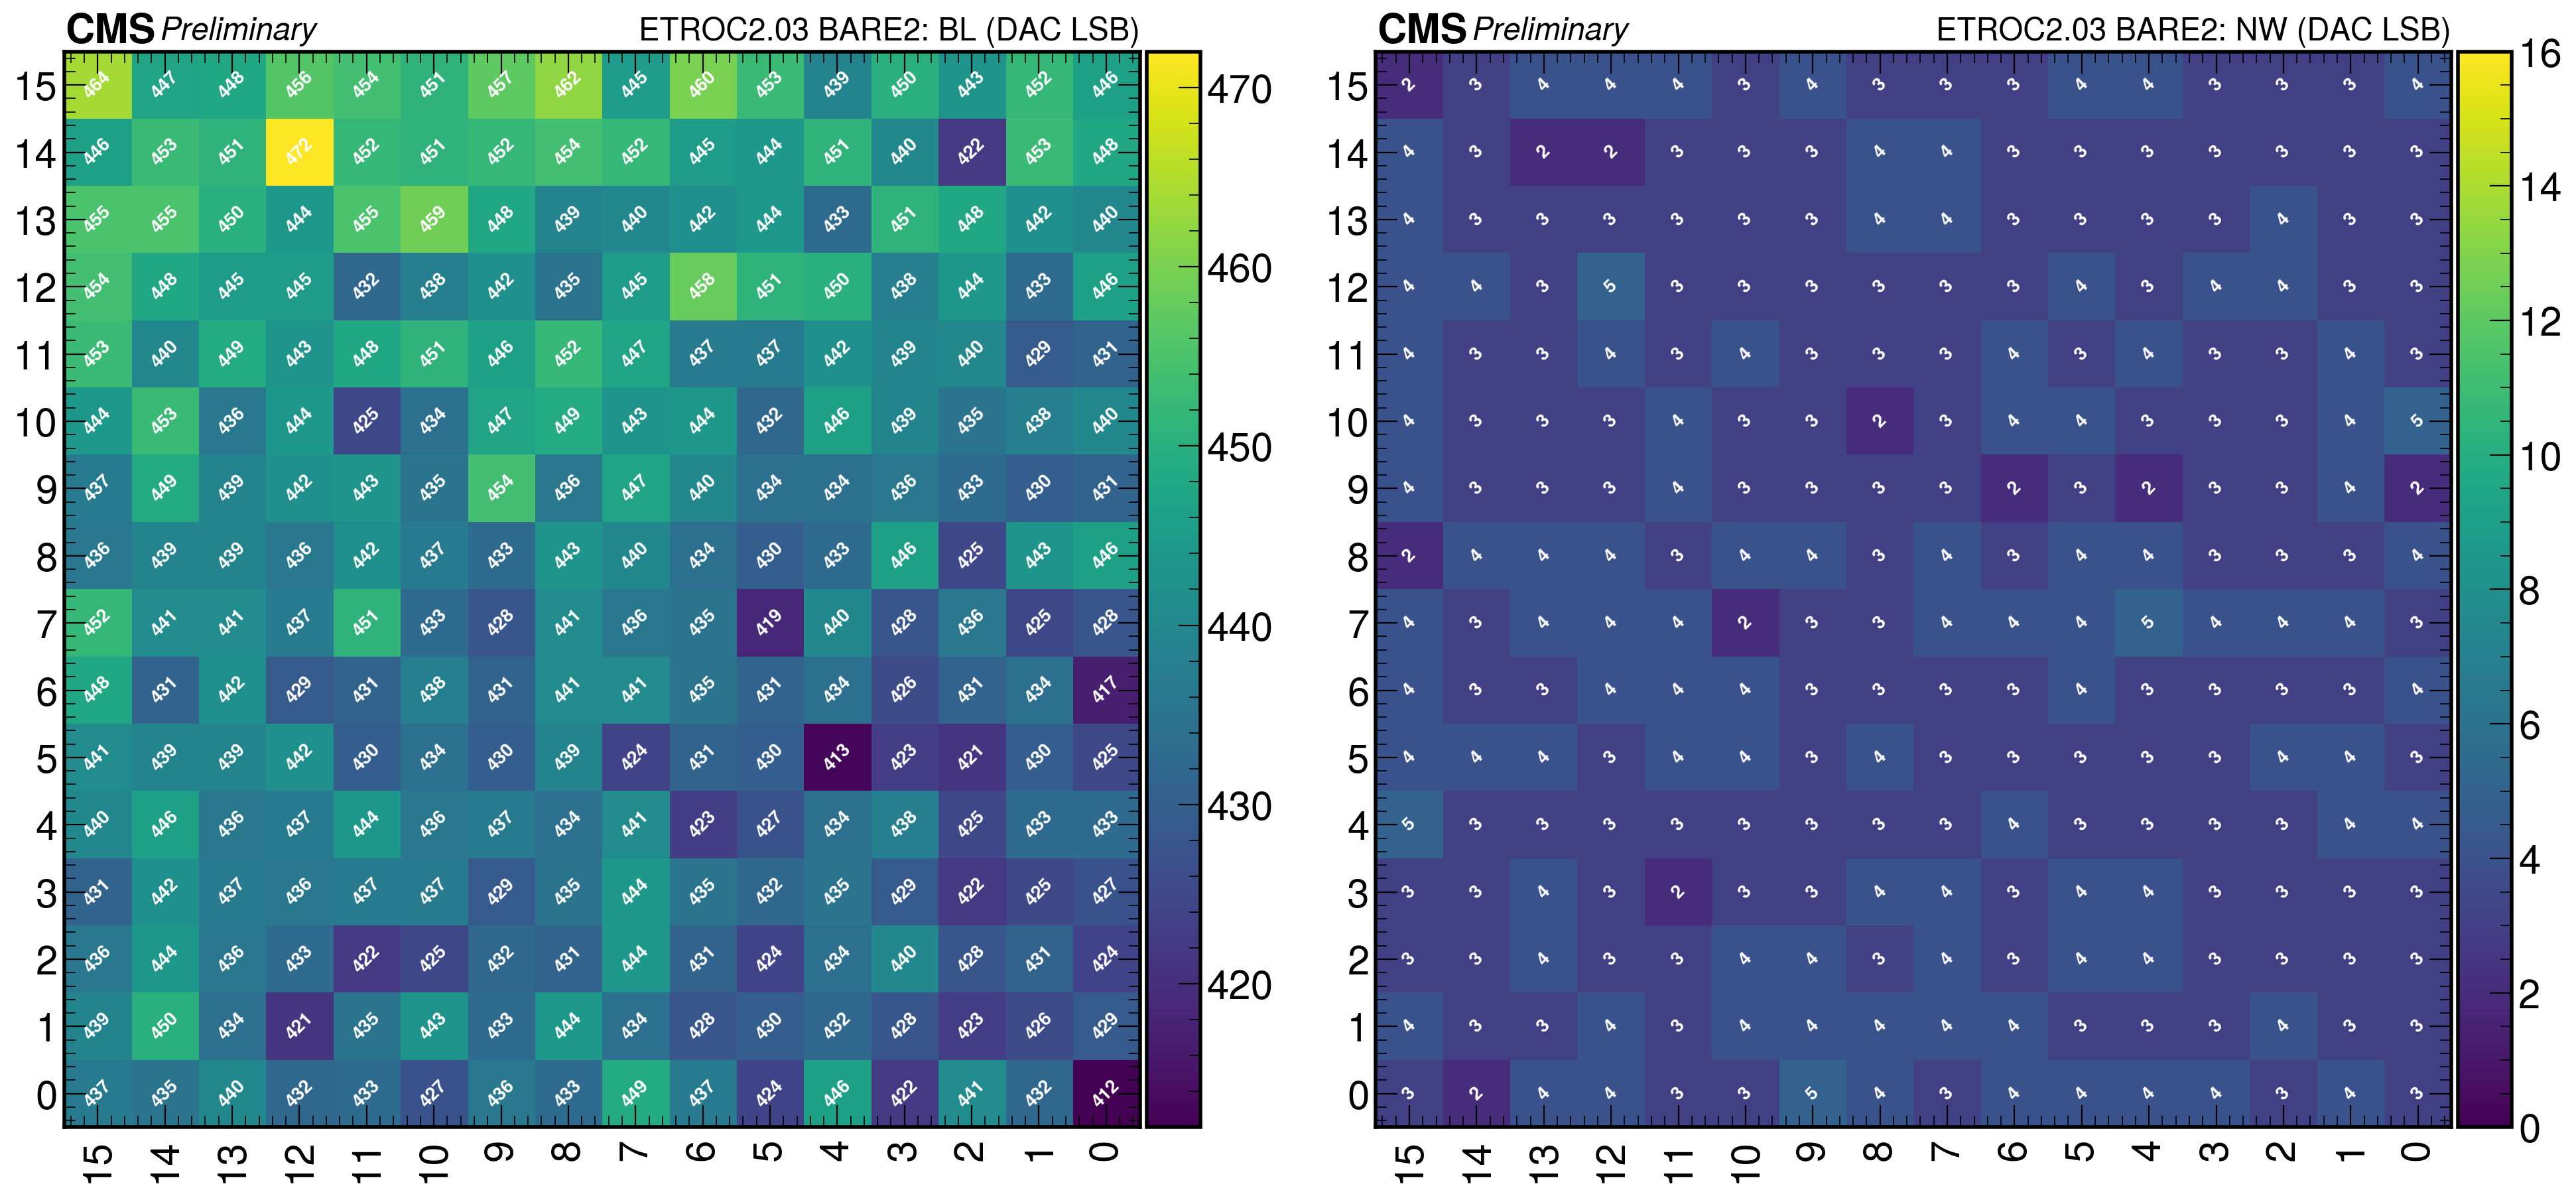

In [6]:
histdir = Path('../ETROC-History/')
histdir.mkdir(exist_ok=True)
histfile = histdir / 'BaselineHistory.sqlite'
i2c_conn.save_baselines(chip_fignames,fig_path,histdir,histfile)

In [ ]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.save_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.save_auto_cal_NW_map(chip_address, chip_name, "")

In [ ]:
for chip_address, chip_name in zip(chip_addresses, chip_names):
    i2c_conn.load_auto_cal_BL_map(chip_address, chip_name, "")
    i2c_conn.load_auto_cal_NW_map(chip_address, chip_name, "")

# Define pixels of interest

In [ ]:
# row_list = [14, 14, 14, 14, 15, 15, 15, 15, 2, 2, 2, 2,3, 3, 3, 3]
# col_list = [6, 7, 8, 9, 6, 7, 8, 9, 6, 7, 8, 9, 6, 7, 8, 9]
row_list = [0,0,2,2]
col_list = [8,2,8,2]
# col_list = np.arange(16)
# row_list = np.full_like(col_list,12)
# row_list = np.full_like(col_list,13)
# col_list = [10, 13, 7, 4, 10, 13, 7, 4]
# row_list = [12, 12, 12, 12, 13, 13, 13, 13]
# row_list = [random.randint(0,15) for _ in range (10)]
# col_list = [random.randint(0,15) for _ in range (10)]
# print(np.arange(256))
# rand256 =permutation(np.arange(256))
# print(rand256)
# row_list = rand256[0:4]//16
# col_list = rand256[0:4]%16
scan_list = list(zip(row_list, col_list))

# col_list, row_list = np.meshgrid(np.arange(16),np.arange(16))
# scan_list = list(zip(row_list.flatten(),col_list.flatten()))

print(scan_list)

### Enable pixels of Interest

In [ ]:
i2c_conn.enable_select_pixels_in_chips(scan_list,QInjEn= True,Bypass_THCal=False,specified_addresses=chip_addresses[:],power_mode='high', verbose=False)

### Set offset for all boards

In [ ]:
offset = 0x0f
for chip_address,chip_name in zip(chip_addresses,chip_names):
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    i2c_conn.set_chip_offsets(chip_address, offset=offset,  pixel_list=scan_list, verbose=True)
    chip=chip,
    del chip

#### Set QSel or TH_offset for all boards

In [ ]:
for chip_address,chip_name in zip(chip_addresses,chip_names):
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in scan_list:
        print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        i2c_conn.pixel_decoded_register_write("QSel", format(0x19, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)
        i2c_conn.pixel_decoded_register_write("selfTestOccupancy", format(0x01, '07b'), chip)
        i2c_conn.pixel_decoded_register_write("workMode", format(0b00, '02b'), chip)
    del row_indexer_handle, column_indexer_handle, chip

### QInj Pixels

In [ ]:
qinj_pixels = {
    0x60: [ # (row, col)
        (6, 6),
    ],
    0x61: [ # (row, col)
        (7, 7),
    ],
    0x62: [ # (row, col)
        (8, 8),
    ],
    0x63: [ # (row, col)
        (9, 9),
    ],
}

for chip_address in chip_addresses:
    if chip_address not in qinj_pixels:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in qinj_pixels[chip_address]:
        print(f"Enabling QInj of chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        # i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
        i2c_conn.pixel_decoded_register_write("QInjEn", '1', chip)


### Set Different offsets for all boards

In [ ]:
board_offsets = {
    0x60: 0x0f,
    0x61: 0x08,
    0x62: 0x0f,
    0x64: 0x08,
}

for chip_address,chip_name in zip(chip_addresses,chip_names):
    if chip_address not in board_offsets:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    i2c_conn.set_chip_offsets(chip_address, chip_name, offset=board_offsets[chip_address], chip=chip, pixel_list=scan_list, verbose=True)
    # row_indexer_handle,_,_ = chip.get_indexer("row")
    # column_indexer_handle,_,_ = chip.get_indexer("column")
    # for row, col in scan_list:
    #     print(f"Operating on chip {hex(chip_address)} Pixel ({row},{col})")
    #     column_indexer_handle.set(col)
    #     row_indexer_handle.set(row)
    #     i2c_conn.pixel_decoded_register_write("QSel", format(0x14, '05b'), chip)
    #     # i2c_conn.pixel_decoded_register_write("TH_offset", format(board_offsets[chip_address], '06b'), chip)
    # del row_indexer_handle, column_indexer_handle
    del chip

### Offset Pixel per board

In [ ]:
offset_pixels = {
    0x60: { # (row, col): offset
        (10, 8): 15,
    }
}

for chip_address in chip_addresses:
    if chip_address not in offset_pixels:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in offset_pixels[chip_address]:
        print(f"Setting offset of chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)
        i2c_conn.pixel_decoded_register_write("TH_offset", format(offset_pixels[chip_address][(row, col)], '06b'), chip)

### Remove noisy pixels from Trigger

In [ ]:
# noisy_pixels = {
#     0x60: [ # (row, col)
#         (10, 8),
#         (13, 4),
#         (1, 3)
#     ],
#     0x61: [ # (row, col)
#         (15, 0),
#         (1, 15),
#         (2, 9),
#     ],
#     0x62: [ # (row, col)
#         (14, 2),
#     ],
#     0x63: [ # (row, col)
#         (13, 2),
#         (7, 8),
#     ],
# }

noisy_pixels = {
    0x60: [ # (row, col)
        (0,3)
    ],
}

for chip_address in chip_addresses:
    if chip_address not in noisy_pixels:
        continue
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("rFalseow")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row, col in noisy_pixels[chip_address]:
        print(f"Masking from trigger of chip {hex(chip_address)} Pixel ({row},{col})")
        column_indexer_handle.set(col)
        row_indexer_handle.set(row)

        # i2c_conn.enable_pixel_modular(row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle, QInjEn=False, Bypass_THCal=False, triggerWindow=True, cbWindow=True)
        # i2c_conn.pixel_decoded_register_write("TH_offset", format(offset, '06b'), chip)

        i2c_conn.disable_pixel(row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
        # i2c_conn.pixel_decoded_register_write("disTrigPath", "1", chip)
        #i2c_conn.pixel_decoded_register_write("DAC", format(1023, '010b'), chip)
        #i2c_conn.pixel_decoded_register_write("Bypass_THCal", "0", chip)



### Disable Pixels of Interest

In [ ]:
for chip_address in chip_addresses[:]:
    chip = i2c_conn.get_chip_i2c_connection(chip_address)
    row_indexer_handle,_,_ = chip.get_indexer("row")
    column_indexer_handle,_,_ = chip.get_indexer("column")
    for row,col in scan_list:
        i2c_conn.disable_pixel(row=row, col=col, verbose=True, chip_address=chip_address, chip=chip, row_indexer_handle=row_indexer_handle, column_indexer_handle=column_indexer_handle)
    del chip, row_indexer_handle, column_indexer_handle

# Calibrate FC for all I2C

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.asyResetGlobalReadout(chip_address, chip=None)
    i2c_conn.asyAlignFastcommand(chip_address, chip=None)

# Calibrate PLL

In [ ]:
for chip_address in chip_addresses[:]:
    i2c_conn.calibratePLL(chip_address, chip=None)

# Disconnect I2C Device

## DO THIS IF YOU PLAN TO DO NOISE STUDIES

In [ ]:
del i2c_conn

In [ ]:
hostname = "192.168.2.3"
polarity = "0x40a1" # "0x0023" or "0x0027"

# pixelnumber_list = [8,9,10,11,12,13,8,9,10,11,12,13,15,16,17,18,19,20,128,129,130,131,132,133]
pixelnumber_list = [16]
ratelist = [67]

for i in range(1):
    for j in range(1):
        rand256 =permutation(np.arange(256))
        row_list = rand256[0:pixelnumber_list[i]]//16
        col_list = rand256[0:pixelnumber_list[i]]%16
        scan_list = list(zip(row_list, col_list))
        print(scan_list)
    
        i2c_conn.enable_select_pixels_in_chips(scan_list,QInjEn= True,Bypass_THCal=True,specified_addresses=chip_addresses[:],power_mode='high')

        offset = 0x0f
        for chip_address,chip_name in zip(chip_addresses,chip_names):
            chip = i2c_conn.get_chip_i2c_connection(chip_address)
            i2c_conn.set_chip_offsets(chip_address, offset=offset,  pixel_list=scan_list, verbose=True)
            chip=chip,
            del chip

        
        parser = parser_arguments.create_parser()
        (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 300 -o 1_2V320M_overflow_pixel{pixelnumber_list[i]}_{ratelist[i]} -v -w -s 0x0000 -p {polarity} -d 0x1800 -a 0x0001 --clear_fifo --start_DAQ_pulse --stop_DAQ_pulse --check_valid_data_start --skip_binary --ssd".split())
        IPC_queue = multiprocessing.Queue()
        process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, None))
        process.start()


        IPC_queue.put(f'memoFC Start QInj repeatedQInj={ratelist[i]} L1A L1ARange BCR uniform')
        # IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR') 

        while not IPC_queue.empty():
            pass
        time.sleep(295)
        IPC_queue.put('stop DAQ')
        IPC_queue.put('memoFC')
        while not IPC_queue.empty():
            pass
        IPC_queue.put('allow threads to exit')
        process.join()

        del IPC_queue, process, parser
        i2c_conn.enable_select_pixels_in_chips(scan_list,QInjEn= False,Bypass_THCal=True,specified_addresses=chip_addresses[:],power_mode='high')
        time.sleep(5)

In [ ]:
hostname = "192.168.2.3"
polarity = "0x40a1" # "0x0023" or "0x0027"

pixelnumber_list = 18

for i in range(pixelnumber_list):
    
    handle = chip.get_decoded_display_var("ETROC2", "Peripheral Config", "chargeInjectionDelay")           # Set data output to right port only
    handle.set(hex(i))
    chip.write_all_block("ETROC2", "Peripheral Config")

    parser = parser_arguments.create_parser()
    (options, args) = parser.parse_args(args=f"-f --useIPC --hostname {hostname} -t 60 -o overnight_loop{i} -v -w -s 0x0020 -p {polarity} -d 0x1800 -a 0x0001 --clear_fifo --start_DAQ_pulse --stop_DAQ_pulse --check_valid_data_start --ssd".split())
    IPC_queue = multiprocessing.Queue()
    process = multiprocessing.Process(target=run_script.main_process, args=(IPC_queue, options, None))
    process.start()


    IPC_queue.put(f'memoFC Start QInj repeatedQInj=67 L1A L1ARange BCR uniform')
        # IPC_queue.put('memoFC Start Triggerbit QInj L1A BCR') 

    while not IPC_queue.empty():
            pass
    time.sleep(55)
    IPC_queue.put('stop DAQ')
    IPC_queue.put('memoFC')
    while not IPC_queue.empty():
        pass
    IPC_queue.put('allow threads to exit')
    process.join()

    del IPC_queue, process, parser